In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
# Data loading and transformation

#TODO transforms.Normalize((0.5,), (0.5,)
transform = transforms.Compose([transforms.ToTensor()])
#TODO
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 12)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(12, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 4, 4)
        x = F.relu(self.deconv1(x))  # Output shape: (batch_size, 64, 8, 8)
        x = self.deconv2(x)  # Output shape: (batch_size, 32, 16, 16)
        x = F.relu(self.bn1(x))
        x = torch.sigmoid(self.deconv3(x))  # Output shape: (batch_size, 1, 28, 28)

        return x


In [ ]:
# Combine Encoder and Decoder into an Autoencoder (same as above)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Model, Loss, Optimizer (same as above)
autoencoder = Autoencoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
 # Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=2048, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  )
)

In [ ]:
num_epochs = 20

# Lists to store losses
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for data, _ in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = autoencoder(data)
            val_loss += criterion(output, data).item()

    test_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {test_losses[-1]:.4f}')



100%|██████████| 938/938 [00:11<00:00, 84.42it/s]


Epoch [1/20], Training Loss: 0.1049, Validation Loss: 0.0685


100%|██████████| 938/938 [00:10<00:00, 88.44it/s]


Epoch [2/20], Training Loss: 0.0617, Validation Loss: 0.0545


100%|██████████| 938/938 [00:10<00:00, 87.92it/s]


Epoch [3/20], Training Loss: 0.0501, Validation Loss: 0.0452


100%|██████████| 938/938 [00:10<00:00, 87.86it/s]


Epoch [4/20], Training Loss: 0.0423, Validation Loss: 0.0396


100%|██████████| 938/938 [00:11<00:00, 84.48it/s]


Epoch [5/20], Training Loss: 0.0376, Validation Loss: 0.0358


100%|██████████| 938/938 [00:11<00:00, 83.20it/s]


Epoch [6/20], Training Loss: 0.0347, Validation Loss: 0.0334


100%|██████████| 938/938 [00:11<00:00, 80.44it/s]


Epoch [7/20], Training Loss: 0.0328, Validation Loss: 0.0322


100%|██████████| 938/938 [00:10<00:00, 85.78it/s]


Epoch [8/20], Training Loss: 0.0315, Validation Loss: 0.0312


100%|██████████| 938/938 [00:10<00:00, 85.28it/s]


Epoch [9/20], Training Loss: 0.0307, Validation Loss: 0.0304


100%|██████████| 938/938 [00:11<00:00, 85.11it/s]


Epoch [10/20], Training Loss: 0.0300, Validation Loss: 0.0300


100%|██████████| 938/938 [00:11<00:00, 84.55it/s]


Epoch [11/20], Training Loss: 0.0295, Validation Loss: 0.0295


100%|██████████| 938/938 [00:11<00:00, 84.74it/s]


Epoch [12/20], Training Loss: 0.0291, Validation Loss: 0.0294


100%|██████████| 938/938 [00:10<00:00, 85.33it/s]


Epoch [13/20], Training Loss: 0.0288, Validation Loss: 0.0293


100%|██████████| 938/938 [00:10<00:00, 85.37it/s]


Epoch [14/20], Training Loss: 0.0286, Validation Loss: 0.0289


100%|██████████| 938/938 [00:11<00:00, 84.69it/s]


Epoch [15/20], Training Loss: 0.0284, Validation Loss: 0.0288


100%|██████████| 938/938 [00:11<00:00, 82.86it/s]


Epoch [16/20], Training Loss: 0.0282, Validation Loss: 0.0285


100%|██████████| 938/938 [00:11<00:00, 84.46it/s]


Epoch [17/20], Training Loss: 0.0280, Validation Loss: 0.0285


100%|██████████| 938/938 [00:11<00:00, 84.47it/s]


Epoch [18/20], Training Loss: 0.0279, Validation Loss: 0.0284


100%|██████████| 938/938 [00:10<00:00, 85.38it/s]


Epoch [19/20], Training Loss: 0.0277, Validation Loss: 0.0282


100%|██████████| 938/938 [00:11<00:00, 84.48it/s]


Epoch [20/20], Training Loss: 0.0276, Validation Loss: 0.0281


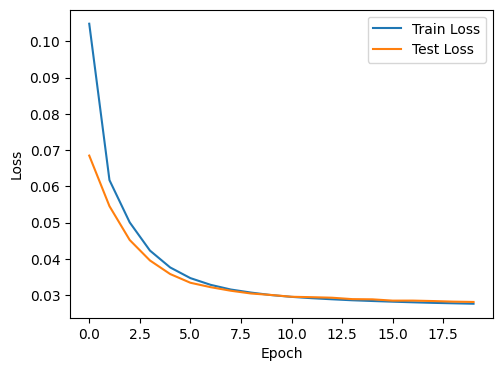

In [ ]:
# Plotting training and test losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

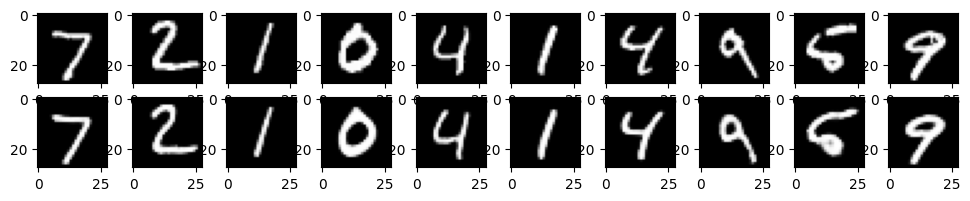

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming `autoencoder` is already defined and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of test data
_, (images, _) = next(enumerate(test_loader))   # Directly fetch the next batch

# Move images to GPU if available
images = images.to(device)

# Generate output from the autoencoder
with torch.no_grad():
    output = autoencoder(images)

# Move output back to CPU if necessary for plotting
output = output.cpu()

# Plot input and output images
fig, axes = plt.subplots(2, 10, figsize=(12, 2))
for i in range(10):
    axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].imshow(output[i].squeeze().numpy(), cmap='gray')

plt.show()


## Load the 100-samples dataset

In [ ]:
# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor()])

train_loader = datasets.MNIST('./data',
                              train= True,
                             download=True,
                             transform = transform)
indices = torch.arange(100)
train_loader = Subset(train_loader, indices)
train_loader = DataLoader(train_loader, batch_size=64,shuffle=True, num_workers=0)


test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(12,32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, some_encoder):
        super(CombinedModel, self).__init__()
        self.my_encoder = some_encoder
        self.classifier = Classifier()

    def forward(self, x):
        x = self.my_encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
model = CombinedModel(autoencoder.encoder).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


100%|██████████| 1250/1250 [00:02<00:00, 512.48it/s]


Epoch [1/30], Train Loss: 2.2588, Train Acc: 27.00%, Test Loss: 2.2257, Test Acc: 23.73%


100%|██████████| 1250/1250 [00:02<00:00, 426.29it/s]


Epoch [2/30], Train Loss: 2.1986, Train Acc: 30.00%, Test Loss: 2.1786, Test Acc: 24.62%


100%|██████████| 1250/1250 [00:02<00:00, 533.57it/s]


Epoch [3/30], Train Loss: 2.1060, Train Acc: 30.00%, Test Loss: 2.1276, Test Acc: 25.45%


100%|██████████| 1250/1250 [00:02<00:00, 525.42it/s]


Epoch [4/30], Train Loss: 2.0101, Train Acc: 33.00%, Test Loss: 2.0719, Test Acc: 26.06%


100%|██████████| 1250/1250 [00:02<00:00, 535.60it/s]


Epoch [5/30], Train Loss: 1.9210, Train Acc: 36.00%, Test Loss: 2.0109, Test Acc: 27.67%


100%|██████████| 1250/1250 [00:02<00:00, 532.30it/s]


Epoch [6/30], Train Loss: 1.8491, Train Acc: 40.00%, Test Loss: 1.9450, Test Acc: 30.41%


100%|██████████| 1250/1250 [00:02<00:00, 426.48it/s]


Epoch [7/30], Train Loss: 1.7351, Train Acc: 44.00%, Test Loss: 1.8735, Test Acc: 34.01%


100%|██████████| 1250/1250 [00:03<00:00, 351.84it/s]


Epoch [8/30], Train Loss: 1.6391, Train Acc: 54.00%, Test Loss: 1.7969, Test Acc: 37.70%


100%|██████████| 1250/1250 [00:02<00:00, 533.38it/s]


Epoch [9/30], Train Loss: 1.5010, Train Acc: 58.00%, Test Loss: 1.7176, Test Acc: 41.01%


100%|██████████| 1250/1250 [00:02<00:00, 536.67it/s]


Epoch [10/30], Train Loss: 1.3707, Train Acc: 59.00%, Test Loss: 1.6349, Test Acc: 43.54%


100%|██████████| 1250/1250 [00:02<00:00, 439.93it/s]


Epoch [11/30], Train Loss: 1.2524, Train Acc: 63.00%, Test Loss: 1.5522, Test Acc: 46.32%


100%|██████████| 1250/1250 [00:02<00:00, 505.96it/s]


Epoch [12/30], Train Loss: 1.0512, Train Acc: 69.00%, Test Loss: 1.4699, Test Acc: 48.98%


100%|██████████| 1250/1250 [00:02<00:00, 542.57it/s]


Epoch [13/30], Train Loss: 0.9810, Train Acc: 72.00%, Test Loss: 1.3892, Test Acc: 51.76%


100%|██████████| 1250/1250 [00:02<00:00, 532.76it/s]


Epoch [14/30], Train Loss: 0.8060, Train Acc: 75.00%, Test Loss: 1.3141, Test Acc: 54.79%


100%|██████████| 1250/1250 [00:02<00:00, 530.93it/s]


Epoch [15/30], Train Loss: 0.7162, Train Acc: 83.00%, Test Loss: 1.2498, Test Acc: 57.06%


100%|██████████| 1250/1250 [00:02<00:00, 418.83it/s]


Epoch [16/30], Train Loss: 0.5805, Train Acc: 84.00%, Test Loss: 1.1964, Test Acc: 59.47%


100%|██████████| 1250/1250 [00:02<00:00, 528.30it/s]


Epoch [17/30], Train Loss: 0.4675, Train Acc: 88.00%, Test Loss: 1.1535, Test Acc: 61.84%


100%|██████████| 1250/1250 [00:02<00:00, 533.98it/s]


Epoch [18/30], Train Loss: 0.4035, Train Acc: 89.00%, Test Loss: 1.1222, Test Acc: 63.65%


100%|██████████| 1250/1250 [00:02<00:00, 543.14it/s]


Epoch [19/30], Train Loss: 0.3180, Train Acc: 89.00%, Test Loss: 1.0915, Test Acc: 65.30%


100%|██████████| 1250/1250 [00:02<00:00, 535.54it/s]


Epoch [20/30], Train Loss: 0.2569, Train Acc: 92.00%, Test Loss: 1.0544, Test Acc: 67.34%


100%|██████████| 1250/1250 [00:02<00:00, 426.47it/s]


Epoch [21/30], Train Loss: 0.1913, Train Acc: 95.00%, Test Loss: 1.0291, Test Acc: 68.67%


100%|██████████| 1250/1250 [00:02<00:00, 530.12it/s]


Epoch [22/30], Train Loss: 0.1433, Train Acc: 98.00%, Test Loss: 1.0117, Test Acc: 69.98%


100%|██████████| 1250/1250 [00:02<00:00, 529.04it/s]


Epoch [23/30], Train Loss: 0.1150, Train Acc: 98.00%, Test Loss: 1.0006, Test Acc: 70.78%


100%|██████████| 1250/1250 [00:02<00:00, 513.85it/s]


Epoch [24/30], Train Loss: 0.0846, Train Acc: 100.00%, Test Loss: 0.9962, Test Acc: 71.37%


100%|██████████| 1250/1250 [00:02<00:00, 519.34it/s]


Epoch [25/30], Train Loss: 0.0607, Train Acc: 100.00%, Test Loss: 0.9951, Test Acc: 72.17%


100%|██████████| 1250/1250 [00:02<00:00, 440.38it/s]


Epoch [26/30], Train Loss: 0.0456, Train Acc: 100.00%, Test Loss: 1.0008, Test Acc: 72.65%


100%|██████████| 1250/1250 [00:02<00:00, 532.76it/s]


Epoch [27/30], Train Loss: 0.0334, Train Acc: 100.00%, Test Loss: 1.0092, Test Acc: 73.05%


100%|██████████| 1250/1250 [00:02<00:00, 536.27it/s]


Epoch [28/30], Train Loss: 0.0245, Train Acc: 100.00%, Test Loss: 1.0236, Test Acc: 73.35%


100%|██████████| 1250/1250 [00:02<00:00, 532.68it/s]


Epoch [29/30], Train Loss: 0.0189, Train Acc: 100.00%, Test Loss: 1.0421, Test Acc: 73.43%


100%|██████████| 1250/1250 [00:02<00:00, 484.82it/s]

Epoch [30/30], Train Loss: 0.0127, Train Acc: 100.00%, Test Loss: 1.0633, Test Acc: 73.39%


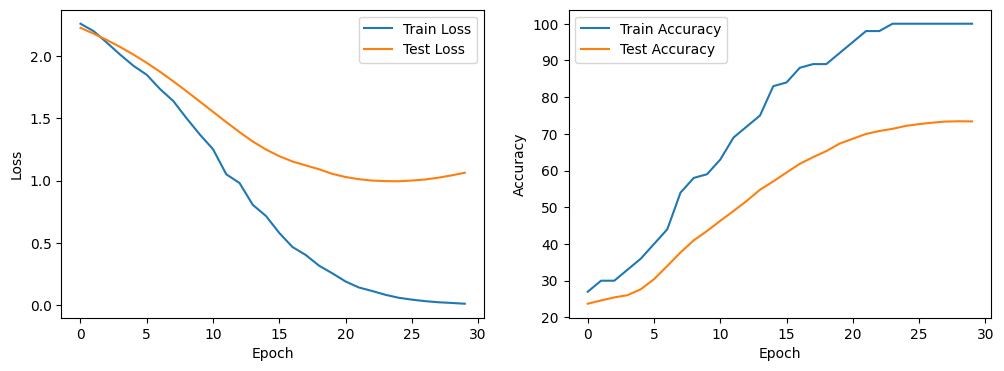

In [ ]:
# Plotting training and test errors and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()